# NLP Deep Dive: RNNs

In [21]:
from IPython.display import display,HTML

A language model is a model that has been trained to guess what the next word in a text is. This kind of task is called `self-supervised learning`: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data. Self-supervised learning is not usually used for the model that is trained directly, but instead is used for pretraining a model used for *transfer learning*. In general in NLP, the pretrained model is trained on a different task.

`Self-supervised learning`: Training a model using labels that are embedded in the independent variable, rather than requiring external labels. For instance, training a model to predict the next word in a text.

The language model we used to classify IMDb reviews was pretrained on Wikipedia. We got great results by directly fine-tuning this language model to a movie review classifier

Even if our language model knows the basics of the language we are using in the task (e.g., our pretrained model is in English), it helps to get used to the style of the corpus we are targeting. It may be more informal language, or more technical, with new words to learn or different ways of composing sentences.

We already saw that with fastai, we can download a pretrained English language model and use it to get state-of-the-art results for NLP classification.

For the *IMDb* sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached. Since there are 25,000 labeled reviews in the training set and 25,000 in the validation set, that makes 100,000 movie reviews altogether. We can use all of these reviews to fine-tune the pretrained language model, which was trained only on *Wikipedia* articles; this will result in a language model that is particularly good at predicting the next word of a movie review.

This is known as the `Universal Language Model Fine-tuning (ULMFit)` approach. Using this approach, we have three stages for transfer learning in NLP

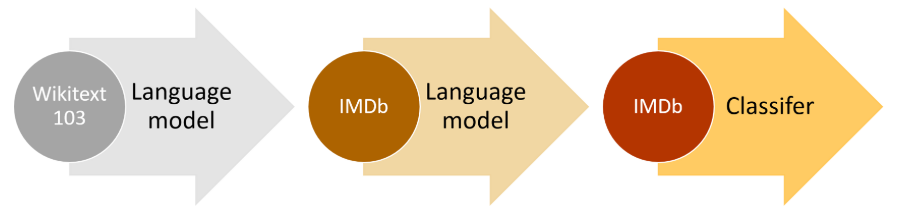

We'll now explore how to apply a neural network to this language modeling problem

#### Text Preprocessing

We've already seen how categorical variables can be used as independent variables for a neural network. The approach we took for a single categorical variable was to:

1. Make a list of all possible levels of that categorical variable (we'll call this list the vocab).
2. Replace each level with its index in the vocab.
3. Create an embedding matrix for this containing a row for each level (i.e., for each item of the vocab).
4. Use this embedding matrix as the first layer of a neural network. (A dedicated embedding matrix can take as inputs the raw vocab indexes created in 5. step 2; this is equivalent to but faster and more efficient than a matrix that takes as input one-hot-encoded vectors representing the indexes.)

We can do nearly the same thing with text! What is new is the idea of a *sequence*. First we *concatenate* all of the documents in our dataset into one big long string and *split it into words*, giving us a very long list of words (or "tokens"). Our `independent variable`(Input Sequence) will be the sequence of words starting with the first word in our very long list and ending with the second to last, and our `dependent variable`(Target Sequence) will be the sequence of words starting with the second word and ending with the last word.

The text "The cat sat on the mat", the input will be ["The", "cat", "sat", "on", "the"] and the target would be ["cat", "sat", "on", "the", "mat"]

Our vocab will consist of a mix of *common words* that are already in the vocabulary of our pretrained model and *new words* specific to our corpus (cinematographic terms or actors names, for instance). Our *embedding matrix* will be built accordingly: for words that are in the vocabulary of our pretrained model, we will take the corresponding row in the embedding matrix of the pretrained model; but for new words we won't have anything, so we will just initialize the corresponding row with a random vector.

Each of the steps necessary to create a language model has jargon associated with it from the world of natural language processing, and fastai and PyTorch classes available to help. The steps are:

1. `Tokenization`: Convert the text into a list of words (or characters, or substrings, depending on the granularity of your model)
2. `Numericalization`: Make a list of all of the unique words that appear (the vocab), and convert each word into a number, by looking up its index in the vocab
3. Language model `data loader` creation:: fastai provides an LMDataLoader class which automatically handles creating a `dependent variable` that is offset from the `independent variable` by one token. It also handles some important details, such as how to shuffle the training data in such a way that the dependent and independent variables maintain their structure as required
4. Language `model` creation:: We need a special kind of model that does something we haven't seen before: handles input lists which could be arbitrarily big or small. There are a number of ways to do this; in this chapter we will be using a `recurrent neural network (RNN)`.

#### Tokenization

When we said "convert the text into a list of words," we left out a lot of details. For instance, what do we do with punctuation? How do we deal with a word like "don't"? Is it one word, or two? What about long medical or chemical words? Should they be split into their separate pieces of meaning? How about hyphenated words? What about languages like German and Polish where we can create really long words from many, many pieces? What about languages like Japanese and Chinese that don't use bases at all, and don't really have a well-defined idea of word?

Because there is no one correct answer to these questions, there is no one approach to tokenization. There are three main approaches:

1. *Word*-based: Split a sentence on spaces, as well as applying language-specific rules to try to separate parts of meaning even when there are no spaces (such as turning "don't" into "do n't"). Generally, punctuation marks are also split into separate tokens.
2. *Subword* based: Split words into smaller parts, based on the most commonly occurring substrings. For instance, "occasion" might be tokenized as "o c ca sion."
3. *Character*-based: Split a sentence into its individual characters.

`Token`: One element of a list created by the tokenization process. It could be a word, part of a word (a subword), or a single character.

#### Word Tokenization with fastai

Rather than providing its own tokenizers, fastai instead provides a consistent interface to a range of tokenizers in external libraries.

Let's try it out with the IMDb dataset that we used

In [1]:
from fastai.text.all import *
path = untar_data(URLs.IMDB)

We'll need to grab the text files in order to try out a tokenizer. Just like `get_image_files`, which we've used many times already, gets all the image files in a path, `get_text_files` gets all the text files in a path. We can also optionally pass `folders` to restrict the search to a particular list of subfolders:

In [2]:
files = get_text_files(path, folders = ['train', 'test', 'unsup'])

Here's a review that we'll tokenize (we'll just print the start of it here to save space):

In [3]:
txt = files[0].open().read(); txt[:75]

'What could have been an excellent hostage movie was totally ruined by what '

the default English word tokenizer for fastai uses a library called *spaCy*. Rather than directly using `SpacyTokenizer`, however, we'll use `WordTokenizer`, since that will always point to fastai's current default word tokenizer

We'll use fastai's `coll_repr(collection, n)` function to display the results. This displays the first `n` items of `collection`, along with the full size—it's what `L` uses by default. Note that fastai's tokenizers take a collection of documents to tokenize, so we have to wrap `txt` in a list:

In [4]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

(#195) ['What','could','have','been','an','excellent','hostage','movie','was','totally','ruined','by','what','apparently','looks','like','a','bored','director','...','there','were','so','many','directions','that','the','movie','could','have'...]


As you see, spaCy has mainly just separated out the words and punctuation. Tokenization is a surprisingly subtle task, when you think about all the little details that have to be handled. Fortunately, spaCy handles these pretty well for us—for instance, here we see that "." is separated when it terminates a sentence, but not in an acronym or number:

In [5]:
first(spacy(['The U.S. dollar 1.00.']))

(#5) ['The','U.S.','dollar','1.00','.']

fastai then adds some additional functionality to the tokenization process with the `Tokenizer` class:

In [6]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 31))

(#207) ['xxbos','xxmaj','what','could','have','been','an','excellent','hostage','movie','was','totally','ruined','by','what','apparently','looks','like','a','bored','director','…','there','were','so','many','directions','that','the','movie','could'...]


Notice that there are now some tokens that start with the characters "xx", which is not a common word prefix in English. These are *special tokens*.

For example, the first item in the list, `xxbos`, is a special token that indicates the start of a new text ("BOS" is a standard NLP acronym that means "beginning of stream"). By recognizing this start token, the model will be able to learn it needs to "forget" what was said previously and focus on upcoming words.

These special tokens don't come from spaCy directly. They are there because fastai adds them by default, by applying a number of rules when processing text. These rules are designed to make it easier for a model to recognize the important parts of a sentence. In a sense, we are translating the original English language sequence into a simplified tokenized language—a language that is designed to be easy for a model to learn.

For instance, the rules will replace a sequence of four exclamation points with a special repeated character token, followed by the number four, and then a single exclamation point. In this way, the model's embedding matrix can encode information about general concepts such as repeated punctuation rather than requiring a separate token for every number of repetitions of every punctuation mark. Similarly, a capitalized word will be replaced with a special capitalization token, followed by the lowercase version of the word. This way, the embedding matrix only needs the lowercase versions of the words, saving compute and memory resources, but can still learn the concept of capitalization.

Here are some of the main special tokens you'll see:

1. `xxbos`: Indicates the beginning of a text (here, a review)
2. `xxmaj`: Indicates the next word begins with a capital (since we lowercased everything)
3. `xxunk`: Indicates the word is unknown

To see the rules that were used, you can check the default rules:

In [7]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html(x)>,
 <function fastai.text.core.replace_rep(t)>,
 <function fastai.text.core.replace_wrep(t)>,
 <function fastai.text.core.spec_add_spaces(t)>,
 <function fastai.text.core.rm_useless_spaces(t)>,
 <function fastai.text.core.replace_all_caps(t)>,
 <function fastai.text.core.replace_maj(t)>,
 <function fastai.text.core.lowercase(t, add_bos=True, add_eos=False)>]

Here is a brief summary of what each does:

1. `fix_html`: Replaces special HTML characters with a readable version (IMDb reviews have quite a few of these)
2. `replace_rep`: Replaces any character repeated three times or more with a special token for repetition (xxrep), the number of times it's repeated, then the character
3. `replace_wrep`: Replaces any word repeated three times or more with a special token for word repetition (xxwrep), the number of times it's repeated, then the word
4. `spec_add_spaces`: Adds spaces around / and #
5. `rm_useless_spaces`: Removes all repetitions of the space character
6. `replace_all_caps`: Lowercases a word written in all caps and adds a special token for all caps (xxup) in front of it
7. `replace_maj`: Lowercases a capitalized word and adds a special token for capitalized (xxmaj) in front of it
8. `lowercase`: Lowercases all text and adds a special token at the beginning (xxbos) and/or the end (xxeos)

Let's take a look at a few of them in action:

In [8]:
coll_repr(tkn('©   Fast.ai www.fast.ai/INDEX'), 31)

"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index']"

#### Subword Tokenization

Word tokenization relies on an assumption that spaces provide a useful separation of components of meaning in a sentence. However, this assumption is not always appropriate. For instance, consider this sentence: 我的名字是郝杰瑞 ("My name is Jeremy Howard" in Chinese). That's not going to work very well with a word tokenizer, because there are no spaces in it! Languages like Chinese and Japanese don't use spaces, and in fact they don't even have a well-defined concept of a "word."

This proceeds in two steps:

1. Analyze a corpus of documents to find the most commonly occurring groups of letters. These become the vocab.
2. Tokenize the corpus using this vocab of *subword units*.

Let's look at an example. For our corpus, we'll use the first 2,000 movie reviews:

In [9]:
txts = L(o.open().read() for o in files[:2000])

We *instantiate* our tokenizer, passing in the *size* of the vocab we want to create, and then we need to "train" it. That is, we need to have it read our documents and find the common sequences of characters to create the vocab. This is done with `setup`. As we'll see shortly, `setup` is a special fastai method that is called automatically in our usual data processing pipelines. Since we're doing everything manually at the moment, however, we have to call it ourselves. Here's a function that does these steps for a given vocab size, and shows an example output:

In [10]:
def subword(sz):
    sp = SubwordTokenizer(vocab_sz=sz)
    sp.setup(txts)
    return ' '.join(first(sp([txt]))[:40])

In [11]:
%pip install sentencepiece!=0.1.90,!=0.1.91

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
subword(1000)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=tmp/texts.out --vocab_size=1000 --model_prefix=tmp/spm --character_coverage=0.99999 --model_type=unigram --unk_id=9 --pad_id=-1 --bos_id=-1 --eos_id=-1 --minloglevel=2 --user_defined_symbols=▁xxunk,▁xxpad,▁xxbos,▁xxeos,▁xxfld,▁xxrep,▁xxwrep,▁xxup,▁xxmaj --hard_vocab_limit=false


'▁What ▁could ▁have ▁been ▁an ▁ex ce ll ent ▁ho st age ▁movie ▁was ▁totally ▁ ru in ed ▁by ▁what ▁apparent ly ▁look s ▁like ▁a ▁bo red ▁director ▁ ... ▁there ▁were ▁so ▁many ▁direction s ▁that ▁the'

When using fastai's subword tokenizer, the special character `▁` represents a space character in the original text.

If we use a smaller vocab, then each token will represent fewer characters, and it will take more tokens to represent a sentence:

In [13]:
subword(200)

'▁ W h a t ▁c o u l d ▁have ▁be en ▁ an ▁ e x ce ll en t ▁h o s t a g e ▁movie ▁was ▁to t al ly ▁ r u in ed'

On the other hand, if we use a larger vocab, then most common English words will end up in the vocab themselves, and we will not need as many to represent a sentence:

In [14]:
subword(10000)

'▁What ▁could ▁have ▁been ▁an ▁excellent ▁hostage ▁movie ▁was ▁totally ▁ruined ▁by ▁what ▁apparently ▁looks ▁like ▁a ▁bored ▁director ▁... ▁there ▁were ▁so ▁many ▁direction s ▁that ▁the ▁movie ▁could ▁have ▁taken ▁... ▁a ▁vampire ▁slash - fest ▁was ▁not'

Picking a subword vocab size represents a compromise: a larger vocab means fewer tokens per sentence, which means faster training, less memory, and less state for the model to remember; but on the downside, it means larger embedding matrices, which require more data to learn.

Overall, subword tokenization provides a way to easily scale between `character tokenization` (i.e., using a small subword vocab) and `word tokenization` (i.e., using a large subword vocab), and handles every human language without needing language-specific algorithms to be developed. It can even handle other "languages" such as genomic sequences or MIDI music notation! For this reason, in the last year its popularity has soared, and it seems likely to become the most common tokenization approach

Once our texts have been split into tokens, we need to convert them to numbers.

#### Numericalization with fastai

`Numericalization` is the process of mapping tokens to integers. The steps are basically identical to those necessary to create a Category variable, such as the dependent variable of digits in MNIST:

1. Make a list of all possible levels of that categorical variable (the vocab).
2. Replace each level with its index in the vocab.

Let's take a look at this in action on the word-tokenized text we saw earlier:

In [15]:
toks = tkn(txt)
print(coll_repr(toks, 31))

(#207) ['xxbos','xxmaj','what','could','have','been','an','excellent','hostage','movie','was','totally','ruined','by','what','apparently','looks','like','a','bored','director','…','there','were','so','many','directions','that','the','movie','could'...]


Just like with `SubwordTokenizer`, we need to call `setup` on `Numericalize`; this is how we create the vocab. That means we'll need our tokenized corpus first. Since tokenization takes a while, it's done in parallel by fastai; but for this manual walkthrough, we'll use a small subset:

In [16]:
toks200 = txts[:200].map(tkn)
toks200[0]

(#207) ['xxbos','xxmaj','what','could','have','been','an','excellent','hostage','movie','was','totally','ruined','by','what','apparently','looks','like','a','bored'...]

We can pass this to setup to create our vocab:

In [17]:
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab,20)

'(#1952) [\'xxunk\',\'xxpad\',\'xxbos\',\'xxeos\',\'xxfld\',\'xxrep\',\'xxwrep\',\'xxup\',\'xxmaj\',\'the\',\'.\',\',\',\'a\',\'and\',\'of\',\'to\',\'it\',\'is\',\'i\',\'"\'...]'

The defaults to Numericalize are `min_freq=3`,`max_vocab=60000`. `max_vocab=60000` results in fastai replacing all words other than the most common 60,000 with a special unknown word token, `xxunk`. This is useful to avoid having an overly large embedding matrix, since that can slow down training and use up too much memory, and can also mean that there isn't enough data to train useful representations for rare words. However, this last issue is better handled by setting `min_freq`; the default `min_freq=3` means that any word appearing less than three times is replaced with xxunk.

fastai can also numericalize your dataset using a `vocab` that you provide, by passing a list of words as the vocab parameter.

Once we've created our `Numericalize` object, we can use it as if it were a function:

In [18]:
nums = num(toks)[:20]; nums

TensorText([   2,    8,   60,   84,   38,   92,   61,  496,  935,   26,   23,
             458,    0,   46,   60,  789,  382,   48,   12, 1441])

This time, our tokens have been converted to a tensor of integers that our model can receive. We can check that they map back to the original text:

In [19]:
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj what could have been an excellent hostage movie was totally xxunk by what apparently looks like a bored'

Now that we have numbers, we need to put them in batches for our model.

#### Putting Our Texts into Batches for a Language Model

Because one cannot simply resize text (like in images "computer vision") to a desired length. Also, we want our language model to read text in order, so that it can efficiently predict what the next word is. This means that each new batch should begin precisely where the previous one left off.

Suppose we have the following text:

    In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we 
    will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the
    PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while.

The tokenization process will add special tokens and deal with punctuation to return this text:

    xxbos xxmaj in this chapter , we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the 
    surface . xxmaj first we will look at the processing steps necessary to convert text into numbers and how to customize it . xxmaj by doing 
    this , we 'll have another example of the preprocessor used in the data block xxup api . \n xxmaj then we will study how we build a language model
    and train it for a while .

We now have 90 tokens, separated by spaces. Let's say we want a batch size of 6. We need to break this text into 6 contiguous parts of length 15:

In [22]:
stream = "In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while."
tokens = tkn(stream)
bs,seq_len = 6,15
d_tokens = np.array([tokens[i*seq_len:(i+1)*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter,",",we,will,go,back,over,the,example,of,classifying
movie,reviews,we,studied,in,chapter,1,and,dig,deeper,under,the,surface,.,xxmaj
first,we,will,look,at,the,processing,steps,necessary,to,convert,text,into,numbers,and
how,to,customize,it,.,xxmaj,by,doing,this,",",we,'ll,have,another,example
of,the,preprocessor,used,in,the,data,block,xxup,api,.,\n,xxmaj,then,we
will,study,how,we,build,a,language,model,and,train,it,for,a,while,.


In a perfect world, we could then give this one batch to our model. But that approach doesn't scale, because outside of this toy example it's unlikely that a single batch containing all the texts would fit in our GPU memory (here we have 90 tokens, but all the IMDb reviews together give several million).

So, we need to divide this array more finely into *subarrays* of a fixed sequence length. It is important to maintain order within and across these subarrays, because we will use a model that maintains a state so that it remembers what it read previously when predicting what comes next.

Going back to our previous example with 6 batches of length 15, if we chose a sequence length of 5, that would mean we first feed the following array:

In [23]:
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15:i*15+seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter
movie,reviews,we,studied,in
first,we,will,look,at
how,to,customize,it,.
of,the,preprocessor,used,in
will,study,how,we,build


Then this one:

In [24]:
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+seq_len:i*15+2*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

",",we,will,go,back
chapter,1,and,dig,deeper
the,processing,steps,necessary,to
xxmaj,by,doing,this,","
the,data,block,xxup,api
a,language,model,and,train


And finally:

In [25]:
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+10:i*15+15] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

over,the,example,of,classifying
under,the,surface,.,xxmaj
convert,text,into,numbers,and
we,'ll,have,another,example
.,\n,xxmaj,then,we
it,for,a,while,.


Going back to our movie reviews dataset, the first step is to transform the individual texts into a stream by concatenating them together. As with images, it's best to randomize the order of the inputs, so at the beginning of each epoch we will shuffle the entries to make a new stream (we shuffle the order of the documents, not the order of the words inside them, or the texts would not make sense anymore!).

We then cut this stream into a certain number of batches (which is our batch size). For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens. What is important is that we preserve the order of the tokens (so from 1 to 5,000 for the first mini-stream, then from 5,001 to 10,000...), because we want the model to read continuous rows of text (as in the preceding example). An xxbos token is added at the start of each during preprocessing, so that the model knows when it reads the stream when a new entry is beginning.

So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order

This is all done behind the scenes by the fastai library when we create an `LMDataLoader`. We do this by first applying our Numericalize object to the tokenized texts:

In [26]:
nums200 = toks200.map(num)

and then passing that to `LMDataLoader`:

In [27]:
dl = LMDataLoader(nums200)

Let's confirm that this gives the expected results, by grabbing the first batch:

In [28]:
x,y = first(dl)
x.shape,y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

and then looking at the first row of the `independent variable`, which should be the start of the first text:

In [31]:
' '.join(num.vocab[o] for o in x[0][:20])

'xxbos xxmaj what could have been an excellent hostage movie was totally xxunk by what apparently looks like a bored'

The `dependent variable` is the same thing offset by one token:

In [32]:
' '.join(num.vocab[o] for o in y[0][:20])

'xxmaj what could have been an excellent hostage movie was totally xxunk by what apparently looks like a bored director'

This concludes all the preprocessing steps we need to apply to our data. We are now ready to train our text classifier.